# Машинное обучение, ФКН ВШЭ

# Практическое задание 12. Несбалансированные задачи

## Общая информация
Дата выдачи: 06.06.2023

Мягкий и жесткий дедлайны: 20.06.2023 23:59 MSK

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-xx-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

## О задании

В этом задании мы разберем основные техники работы в задачах, где один из классов занимает существенно меньшую долю выборки, чем остальные. Для простоты мы обойдемся бинарной задачей, тем не менее, во многом данные методы можно перенести и на задачи с б**о**льшим числом классов. Кроме того, вы получите очередной бесценный опыт исследования случайной библиотеки случайных индусов с нуля.

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

from tqdm.auto import tqdm

**Задание -1 (1 балл)**. EDA

В качестве данных для нашей работы возьмем выложенный на kaggle датасет транзакций, в котором нужно выискивать мошеннические проводки: [клик](https://www.kaggle.com/mlg-ulb/creditcardfraud). Данная задача по определению подходит под несбалансированную, что можно сказать даже без наличия каких-либо данных (понятно, что среди всех транзакций клиентов очень малая часть будет мошеннической).

Загрузим данные, проведем некоторые классические манипуляции.

In [3]:
!kaggle datasets download -d mlg-ulb/creditcardfraud
!unzip creditcardfraud.zip

 97%|████████████████████████████████████▉ | 64.0M/66.0M [00:05<00:00, 7.61MB/s]
100%|██████████████████████████████████████| 66.0M/66.0M [00:05<00:00, 13.0MB/s]
Archive:  creditcardfraud.zip
  inflating: creditcard.csv          


In [2]:
df = pd.read_csv('creditcard.csv')

In [14]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


Наши данные были анонимизированы. Мы имеем 30 признаков, из которых 28 - это результаты PCA-преобразования на исходном датасете. Еще 2 признака представляют собой время в секундах, прошедшее с момента первой транзакции в датасете, и размер транзакции. Скажите, какова доля положительных объектов в выборке?

In [15]:
print(f'Доля положительных: {(df["Class"] == 1).sum() / df.shape[0] * 100} %')

Доля положительных: 0.1727485630620034 %


Начнем с обработки времени. Секунды сами по себе не несут большой информации о зависимостях в данных, попробуйте по ним создать признаки "час" (от 0 до 23) и "день" (от 0 до ...) в аналогичной манере (принимая первый объект выборки за начальную точку). Сколько дней покрывают данные?

In [16]:
print('Дней:', np.ceil(df['Time'].max() / (60 * 60 * 24)))

Дней: 2.0


In [3]:
df['Hour'] = df['Time'] // (60 * 60) % 24

In [4]:
df['Day'] = df['Time'] // (60 * 60) // 24

Постройте следующие графики:

1. Распределение числа транзакций по каждому часу (line-plot).
2. Распределение доли мошеннических транзакций по каждому часу (line-plot)
3. То же самое для дней (здесь можно использовать bar-plot, так как дней должно быть немного).

Какие выводы можно сделать из графиков? На ваш взгляд, как можно связать полученные нами часы с реальными часами в сутках?

In [9]:
transaction_per_hour = df.groupby(['Hour']).agg('count')['Class'].tolist()
fraud_per_hour = df[df['Class'] == 1].groupby(['Hour']).agg('count')['Class'].tolist()

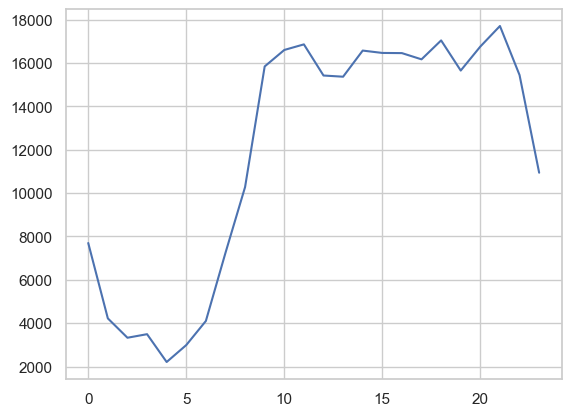

In [10]:
plt.plot(np.arange(24), transaction_per_hour)

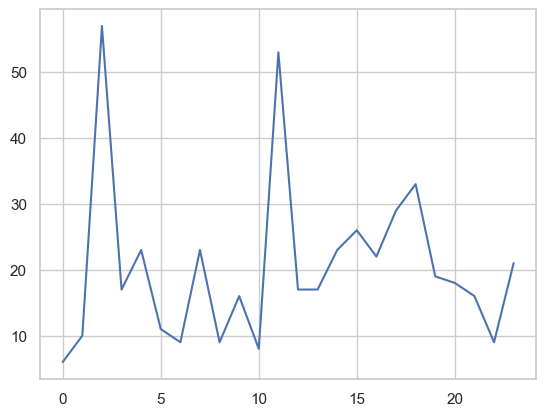

In [11]:
plt.plot(np.arange(24), fraud_per_hour)

Видим, что число транзакций максимально в вечернее время и минимально к 3-4 утра. Мошеннические транзацкии проводятся ночью где то в 2-3 часа, а также утром, в дневное время их число мало

In [12]:
transaction_per_day = df.groupby(['Day']).agg('count')['Class'].tolist()
fraud_per_day = df[df['Class'] == 1].groupby(['Day']).agg('count')['Class'].tolist()

<BarContainer object of 2 artists>

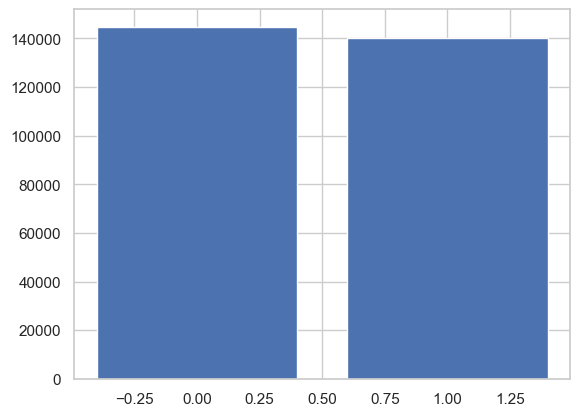

In [15]:
plt.bar([0, 1], transaction_per_day)

<BarContainer object of 2 artists>

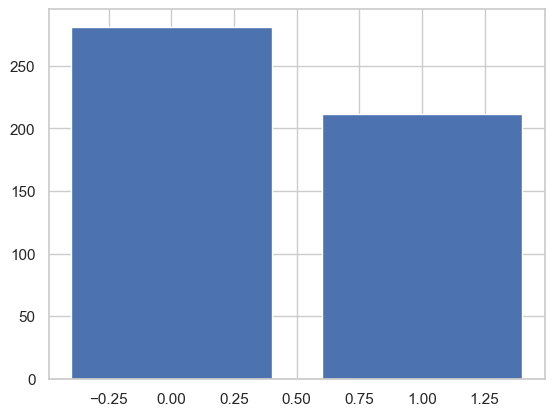

In [16]:
plt.bar([0, 1], fraud_per_day)

Число транзакций, в том числе мошеннеческих в первый день выше

С анонимизированными признаками вряд ли можно придумать что-то интересное. Попробуйте (например, с помощью корреляции?) выбрать несколько наиболее важных признаков и поглядеть на различия в их распределении для разных классов.

In [35]:
df[df.columns].corr()['Class'].abs().sort_values(ascending=False)[1:].reset_index()

,index,Class
0,V17,0.326481
1,V14,0.302544
2,V12,0.260593
3,V10,0.216883
4,V16,0.196539
5,V3,0.192961
6,V7,0.187257
7,V11,0.154876
8,V4,0.133447
9,V18,0.111485


Самыми важными признаками оказались V17, V14, V12, V10, V15, V3, V7, V11, V4, V18, V1, V9, V5, V2. Посмотрим на распределения самых важных из них:

array([<AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'1'}>], dtype=object)

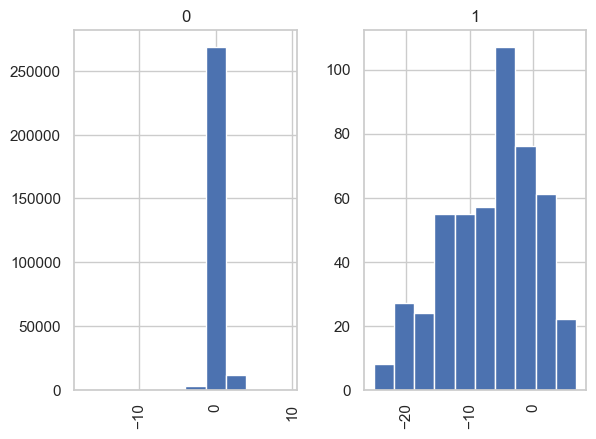

In [43]:
df['V17'].hist(by=df['Class'])

array([<AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'1'}>], dtype=object)

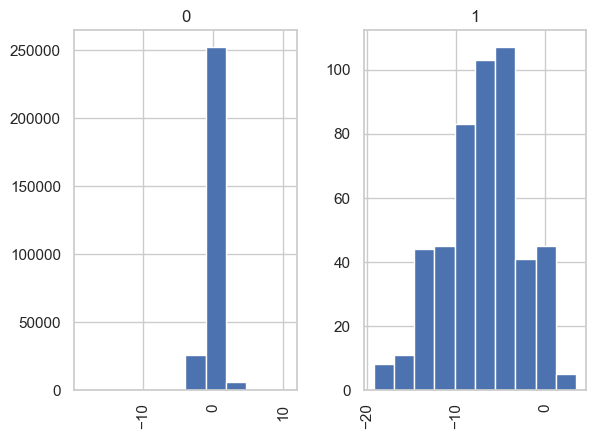

In [44]:
df['V14'].hist(by=df['Class'])

array([<AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'1'}>], dtype=object)

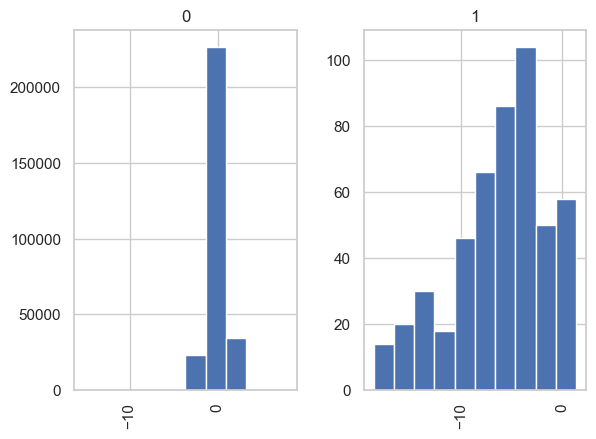

In [45]:
df['V12'].hist(by=df['Class'])

array([<AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'1'}>], dtype=object)

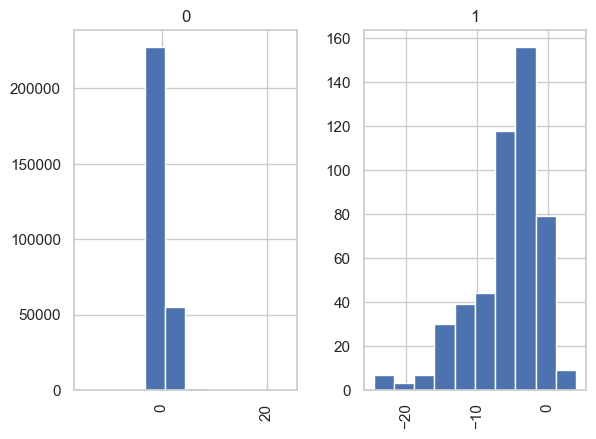

In [46]:
df['V10'].hist(by=df['Class'])

array([<AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'1'}>], dtype=object)

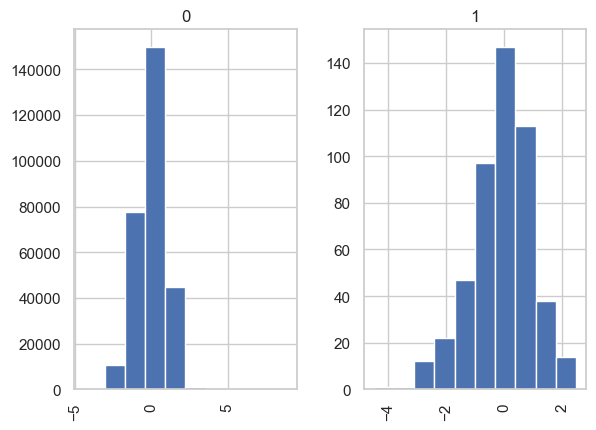

In [47]:
df['V15'].hist(by=df['Class'])

Видно, что у мошеннических транзакций значения признаков имеют большую дисперсию

Теперь давайте разделим данные. Отделите хронологически последние 20% транзакций и поделите их пополам (также хронологически, т.е. без перемешивания) на валидационные и тестовые. Это разбиение не совсем корректно (как можно было заметить, мошеннические транзакции имеют разное распределение во времени - по-хорошему, нам стоило бы выделить целые сутки записей как под валидацию, так и под тест), тем не менее, мы не сможем получить больше данных для адекватного контроля, поэтому обойдемся этим. 

In [5]:
df.sort_values('Time', inplace=True)

In [7]:
df.drop(columns='Time', inplace=True)

In [8]:
X_train = df[:-int(df.shape[0] * 0.2)]
X_test = df[-int(df.shape[0] * 0.2):]
X_val = X_test[:-X_test.shape[0] // 2]
X_test = X_test[-X_test.shape[0] // 2:]

# Часть 1. Несбалансированная классификация.

**Задание 0. (1 балл)**: перед началом работы давайте поговорим о том, как мы будем оценивать качество. Классические метрики для качества классификации чаще всего "ломаются" на задачах с сильным перекосом. Чему будет равно значение accuracy для наивного предсказания (= мажорный класс для каждого объекта)? (можете не отвечать, просто подумайте)

Из курса МО-1 вам уже известно, что мы можем использовать в таких задачах `AUC-PR` и получать адекватные показатели. Можно сказать, что `AUC-PR` представляет собой матожидание `precision` по распределению, заданному выигрышем в `recall` при смене порога. 

Тем не менее, существуют и другие, не менее интересные метрики. Одной из таких метрик является коэффициент Каппа Коэна, представляющий собой нормализованную `accuracy`:

$$\kappa = \frac{p_o - p_e}{1 - p_e}$$

Данная метрика служит в качестве меры согласованности между двумя независимыми предсказателями, но ничего не знает про "верные" и "предсказанные" метки (в отличие от многих других метрик машинного обучения). Здесь $p_o$ - доля согласованных предсказаний, а $p_e$ - доля согласованных предсказаний, которая могла бы получиться при случайных ответах предсказателей. В нашем случае это работает так:

• В качестве $p_o$ берем accuracy

• В качестве $p_e$ примем следующую величину - вероятность случайного соглашения позитивных ответов (произведение долей позитивных ответов в обоих предсказаниях) плюс вероятность случайного соглашения негативных ответов (произведение долей негативных ответов в обоих предсказаниях)

Метрика принимает значения от -1 до 1, где 1 - полная согласованность, 0 - согласованность на уровне рандома, -1 - совсем плохо. Как уже говорилось, метрика не различает "верные" и "предсказанные" метки, поэтому является симметричной (можете использовать это для отладки):

In [14]:
def kappa_coef(y_true, y_pred):
    p0 = sum(y_true == y_pred) / y_pred.shape[0]
    pe = sum(y_true == 1) * sum(y_pred == 1) / y_pred.shape[0]**2 + sum(y_true == 0) * sum(y_pred == 0) / y_pred.shape[0]**2
    return (p0 - pe) / (1 - pe)

Еще одной метрикой в такой задаче служит коэффициент корреляции Мэтьюза, выражающийся в терминах матрицы ошибок следующим образом:

$$\text{MCC} = \frac{TP\times TN - FP \times FN}{\sqrt{(TP+FP)(TP+FN)(TN+FP)(TN+FN)}}$$ 

Метрика принимает значения от -1 до 1, интерпретируемые аналогичным образом. 

In [15]:
from sklearn.metrics import confusion_matrix

def mcc(y_true, y_pred):
    conf = confusion_matrix(y_true, y_pred)
    tp, fp, tn, fn = conf[1][1], conf[0][1], conf[0][0], conf[1][0] 
    upper = tp * tn - fp * fn
    lower = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) + 1e-23
    return upper / lower

Обратите внимание, что эти метрики вычисляются на бинаризованных предсказаниях, поэтому может иметь смысл дополнительная настройка порога бинаризации.

Давайте проверим, что наши метрики действительно подходят под задачу. Вычислите их значения для наивного предсказания (aka мажорный класс для всех объектов):

In [15]:
kappa_coef(np.zeros_like(df['Class']), df['Class'])

0.0

In [16]:
mcc(np.zeros_like(df['Class']), df['Class'])

0.0

In [17]:
mcc(df['Class'] == 0, df['Class'])

-1.0

Видим, что работает корректно

Давайте запустим бейзлайн-решение для нашей задачи. С чего же начнем? Возьмите `catboost` и обучите его классификатор на наших данных (используйте все признаки). Вычислите значения всех метрик на тестовой части, для контроля переобучения используйте валидационную (здесь и далее везде, где фигурирует `catboost`). 

In [18]:
from catboost import CatBoostClassifier

In [19]:
X_train = X_train.astype({"Hour": int, "Day": int})
X_test = X_test.astype({"Hour": int, "Day": int})
X_val = X_val.astype({"Hour": int, "Day": int})

Давайте запустим бейзлайн-решение для нашей задачи. С чего же начнем? Возьмите `catboost` и обучите его классификатор на наших данных (используйте все признаки). Вычислите значения всех метрик на тестовой части, для контроля переобучения используйте валидационную (здесь и далее везде, где фигурирует `catboost`). 

In [171]:
cat_features = [0, 30, 31]
model = CatBoostClassifier(iterations=100,
                           learning_rate=1,
                           depth=4)

model.fit(X_train.drop(columns='Class'), X_train['Class'], cat_features)
preds_class = model.predict(X_test.drop(columns='Class'))

0:	learn: 0.0110384	total: 42.9ms	remaining: 4.25s
1:	learn: 0.0036751	total: 89.1ms	remaining: 4.37s
2:	learn: 0.0031357	total: 144ms	remaining: 4.64s
3:	learn: 0.0030104	total: 189ms	remaining: 4.55s
4:	learn: 0.0028989	total: 235ms	remaining: 4.47s
5:	learn: 0.0027595	total: 286ms	remaining: 4.48s
6:	learn: 0.0026346	total: 332ms	remaining: 4.41s
7:	learn: 0.0026042	total: 398ms	remaining: 4.57s
8:	learn: 0.0025402	total: 461ms	remaining: 4.66s
9:	learn: 0.0024349	total: 522ms	remaining: 4.7s
10:	learn: 0.0023492	total: 587ms	remaining: 4.75s
11:	learn: 0.0023145	total: 690ms	remaining: 5.06s
12:	learn: 0.0022608	total: 748ms	remaining: 5s
13:	learn: 0.0022210	total: 806ms	remaining: 4.95s
14:	learn: 0.0021396	total: 871ms	remaining: 4.94s
15:	learn: 0.0021033	total: 944ms	remaining: 4.96s
16:	learn: 0.0020145	total: 1.01s	remaining: 4.93s
17:	learn: 0.0019881	total: 1.07s	remaining: 4.87s
18:	learn: 0.0019406	total: 1.14s	remaining: 4.84s
19:	learn: 0.0019141	total: 1.19s	remaining

In [180]:
print('val mcc:', mcc(X_val['Class'], model.predict(X_val.drop(columns='Class'))))
print('test mcc:', mcc(X_test['Class'], model.predict(X_test.drop(columns='Class'))))

val mcc: 0.847564803800145
test mcc: 0.7754834690252622


In [181]:
print('val kappa:', kappa_coef(X_val['Class'], model.predict(X_val.drop(columns='Class'))))
print('test kappa:', kappa_coef(X_test['Class'], model.predict(X_test.drop(columns='Class'))))

val kappa: 0.8418450229309994
test kappa: 0.7690752614163152


Если вы все сделали правильно, у вас должны были получиться значения в районе 0.7.

**Задание 1. (1 балл)**. Многие реализации методов предлагают встроенные способы для борьбы с нашей проблемой. Самое часто встречающееся решение - просто добавить вес в функции потерь для минорного класса (таким образом, ошибка на объекте минорного класса будет весить больше, чем для мажорного). В `catboost` это также реализовано, причем для бинарной задачи это можно сделать целыми двумя способами (можете выбрать любой, на свой вкус, автор задания предпочитает отдельный скейлинг для минорного класса). Чаще всего в качестве веса берется отношение числа объектов мажорного класса к числу минорного. Попробуйте обучить модель с таким скалированием и сравните метрики на тестовой части с бейзлайном.

In [220]:
cat_features = [0, 30, 31]
model = CatBoostClassifier(iterations=100,
                           learning_rate=1,
                           depth=4)

weight_coeff = sum(X_train['Class'] == 0) / sum(X_train['Class'] == 1)

model.fit(X_train.drop(columns='Class'), X_train['Class'], cat_features, sample_weight=(X_train['Class'] * weight_coeff + np.uint32(X_train['Class'] == 0)))
preds_class = model.predict(X_test.drop(columns='Class'))

0:	learn: 0.2256270	total: 55.5ms	remaining: 5.49s
1:	learn: 0.1804366	total: 107ms	remaining: 5.23s
2:	learn: 0.1676946	total: 163ms	remaining: 5.26s
3:	learn: 0.1379870	total: 215ms	remaining: 5.16s
4:	learn: 0.1232582	total: 270ms	remaining: 5.13s
5:	learn: 0.1123697	total: 328ms	remaining: 5.13s
6:	learn: 0.1044038	total: 393ms	remaining: 5.22s
7:	learn: 0.0944178	total: 444ms	remaining: 5.1s
8:	learn: 0.0873352	total: 502ms	remaining: 5.08s
9:	learn: 0.0793692	total: 557ms	remaining: 5.01s
10:	learn: 0.0725146	total: 604ms	remaining: 4.89s
11:	learn: 0.0657326	total: 653ms	remaining: 4.79s
12:	learn: 0.0604188	total: 704ms	remaining: 4.71s
13:	learn: 0.0550806	total: 763ms	remaining: 4.69s
14:	learn: 0.0503079	total: 811ms	remaining: 4.6s
15:	learn: 0.0463380	total: 854ms	remaining: 4.48s
16:	learn: 0.0420793	total: 896ms	remaining: 4.37s
17:	learn: 0.0372131	total: 944ms	remaining: 4.3s
18:	learn: 0.0319545	total: 987ms	remaining: 4.21s
19:	learn: 0.0287148	total: 1.03s	remaining

In [221]:
print('val kappa:', kappa_coef(X_val['Class'], model.predict(X_val.drop(columns='Class'))))
print('test kappa:', kappa_coef(X_test['Class'], model.predict(X_test.drop(columns='Class')))) 
print('val mcc:', mcc(X_val['Class'], model.predict(X_val.drop(columns='Class'))))
print('test mcc:', mcc(X_test['Class'], model.predict(X_test.drop(columns='Class'))))

val kappa: 0.7688088065877764
test kappa: 0.4770693409616061
val mcc: 0.7689515280727256
test mcc: 0.5080062050334478


поломалось

Поскольку данный вес будет являться гиперпараметром метода, было бы опрометчиво остановиться на одном значении (тем более, с большой вероятностью у вас все сломалось). Запустите перебор для этого гиперпараметра на валидационной выборке (используйте `PR-AUC`), подберите оптимальный порог бинаризации для $\kappa$ или $\text{MCC}$. Для лучшего найденного веса и порога вычислите все метрики на тестовой части. 

При этом можете также проверить отдельное скалирование в большую сторону для мажорного класса (т.е. веса минорного сделать меньше 1) и экстремальные скалирования (т.е. веса минорного больше, чем в начале этого задания). Какой вес получился оптимальным?

In [213]:
import optuna
from sklearn.metrics import average_precision_score

def objective(trial):
    cat_features = [0, 30, 31]
    model = CatBoostClassifier(iterations=100,
                            learning_rate=1,
                            depth=4, verbose=False)
    weight_coeff = trial.suggest_float('wc', 1.0, 100.0)
    model.fit(X_train.drop(columns='Class'), X_train['Class'], cat_features, sample_weight=(X_train['Class'] * weight_coeff + np.uint32(X_train['Class'] == 0)))
    preds_class = model.predict(X_val.drop(columns='Class'))
    return average_precision_score(X_val['Class'], preds_class)


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2023-06-15 23:14:44,644] A new study created in memory with name: no-name-793679a1-8ba3-487e-b5b4-9bd6ec3ab096
[I 2023-06-15 23:14:50,272] Trial 0 finished with value: 0.6752507341034466 and parameters: {'wc': 64.9038740384552}. Best is trial 0 with value: 0.6752507341034466.
[I 2023-06-15 23:14:55,102] Trial 1 finished with value: 0.5861673527795684 and parameters: {'wc': 91.55530934036888}. Best is trial 0 with value: 0.6752507341034466.
[I 2023-06-15 23:15:00,222] Trial 2 finished with value: 0.6243635992847332 and parameters: {'wc': 20.877599563464383}. Best is trial 0 with value: 0.6752507341034466.
[I 2023-06-15 23:15:05,403] Trial 3 finished with value: 0.5700541822832709 and parameters: {'wc': 52.897010822712915}. Best is trial 0 with value: 0.6752507341034466.
[I 2023-06-15 23:15:10,601] Trial 4 finished with value: 0.5744538371846513 and parameters: {'wc': 98.25617537942266}. Best is trial 0 with value: 0.6752507341034466.
[I 2023-06-15 23:15:15,830] Trial 5 finished with 

In [214]:
study.best_params

{'wc': 13.151885856410988}

In [216]:
weight_coeff = 13.151885856410988
cat_features = [0, 30, 31]
model = CatBoostClassifier(iterations=100, learning_rate=1, depth=4, verbose=False)
model.fit(X_train.drop(columns='Class'), X_train['Class'], cat_features, sample_weight=(X_train['Class'] * weight_coeff + np.uint32(X_train['Class'] == 0)))

def objective(trial):
    prob_threshold = trial.suggest_float('prob_threshold', 0.0, 1.0)
    model.set_probability_threshold(prob_threshold)
    preds_class = model.predict(X_val.drop(columns='Class'))
    return mcc(X_val['Class'], preds_class)


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)

[I 2023-06-15 23:57:01,434] A new study created in memory with name: no-name-3b4e6617-a7c5-4259-a5da-78518a432a20
[I 2023-06-15 23:57:01,484] Trial 0 finished with value: 0.8578635968833646 and parameters: {'prob_threshold': 0.6532611619513213}. Best is trial 0 with value: 0.8578635968833646.
[I 2023-06-15 23:57:01,532] Trial 1 finished with value: 0.8242055888049206 and parameters: {'prob_threshold': 0.8662155036373123}. Best is trial 0 with value: 0.8578635968833646.
[I 2023-06-15 23:57:01,574] Trial 2 finished with value: 0.8467917789048397 and parameters: {'prob_threshold': 0.7966073826338668}. Best is trial 0 with value: 0.8578635968833646.
[I 2023-06-15 23:57:01,617] Trial 3 finished with value: 0.8126789775461831 and parameters: {'prob_threshold': 0.919827002563917}. Best is trial 0 with value: 0.8578635968833646.
[I 2023-06-15 23:57:01,664] Trial 4 finished with value: 0.7205781195912261 and parameters: {'prob_threshold': 0.05934627084090904}. Best is trial 0 with value: 0.8578

In [217]:
study.best_params

{'prob_threshold': 0.5682578070562174}

In [223]:
cat_features = [0, 30, 31]
model = CatBoostClassifier(iterations=100,
                        learning_rate=1,
                        depth=4, verbose=False)
weight_coeff = 13.151885856410988
prob_threshold = 0.5682578070562174
model.fit(X_train.drop(columns='Class'), X_train['Class'], cat_features, sample_weight=(X_train['Class'] * weight_coeff + np.uint32(X_train['Class'] == 0)))
model.set_probability_threshold(prob_threshold)

In [224]:
print('val kappa:', kappa_coef(X_val['Class'], model.predict(X_val.drop(columns='Class'))))
print('test kappa:', kappa_coef(X_test['Class'], model.predict(X_test.drop(columns='Class')))) 
print('val mcc:', mcc(X_val['Class'], model.predict(X_val.drop(columns='Class'))))
print('test mcc:', mcc(X_test['Class'], model.predict(X_test.drop(columns='Class'))))

val kappa: 0.8747912638183588
test kappa: 0.6508994009441134
val mcc: 0.8795924123599013
test mcc: 0.6510757523867478


ну было лучше

**Задание 2. (1 балл)**. На самом деле, то, что мы сейчас делали, очень схоже с другой распространенной техникой - оверсэмплингом. Фактически, мы можем продублировать все объекты минорного класса и получить тот же эффект, какой был бы при использовании веса, равного 2. Тем не менее, такой подход - это лишь малая часть того, что мы можем проделать с целью повысить число объектов минорного класса. 

Для продолжения работы установим библиотеку [imbalanced-learn](https://imbalanced-learn.org/stable/):

In [225]:
!pip3 install imbalanced-learn

Первый метод, которым мы воспользуемся, называется SMOTE (его вы уже разбирали на лекции). Кратко напомним суть: мы выбираем случайного кандидата среди $k$ ближайших соседей объекта минорного класса, затем берем точку на отрезке между двумя объектами (т.е. выпуклую комбинацию со случайными коэффициентами) и добавляем в выборку. 

In [13]:
from imblearn.over_sampling import SMOTE

Используйте SMOTE для ресэмплинга обучающей выборки, на новой выборке обучите модель (вес положительных объектов скалировать не нужно). Замерьте качество на тестовой выборке (**важно!** не преобразовывайте валидационную и тестовую выборку никак - мы не хотим отслеживать качество на объектах, которых в реальности не существует). Сравните полное выравнивание выборки с частичным (т.е. таким, что баланс классов улучшается, но не достигает равенства - скажем, 1:2 и 1:10).

In [239]:
sm = SMOTE(random_state=42, sampling_strategy=1)
X_res, y_res = sm.fit_resample(X_train.drop(columns='Class'), X_train['Class'])
cat_features = [0, 30, 31]
model = CatBoostClassifier(iterations=100,
                            learning_rate=1,
                            depth=4, verbose=False)
model.fit(X_res, y_res, cat_features)
print('val kappa:', kappa_coef(X_val['Class'], model.predict(X_val.drop(columns='Class'))))
print('test kappa:', kappa_coef(X_test['Class'], model.predict(X_test.drop(columns='Class')))) 
print('val mcc:', mcc(X_val['Class'], model.predict(X_val.drop(columns='Class'))))
print('test mcc:', mcc(X_test['Class'], model.predict(X_test.drop(columns='Class'))))

val kappa: 0.5948034521180404
test kappa: 0.3648422726109298
val mcc: 0.6141151478845108
test mcc: 0.42945223421131207


In [242]:
sm = SMOTE(random_state=42, sampling_strategy=0.5)
X_res, y_res = sm.fit_resample(X_train.drop(columns='Class'), X_train['Class'])
cat_features = [0, 30, 31]
model = CatBoostClassifier(iterations=100,
                        learning_rate=1,
                        depth=4, verbose=False)
model.fit(X_res, y_res, cat_features)
print('val kappa:', kappa_coef(X_val['Class'], model.predict(X_val.drop(columns='Class'))))
print('test kappa:', kappa_coef(X_test['Class'], model.predict(X_test.drop(columns='Class')))) 
print('val mcc:', mcc(X_val['Class'], model.predict(X_val.drop(columns='Class'))))
print('test mcc:', mcc(X_test['Class'], model.predict(X_test.drop(columns='Class'))))

val kappa: 0.7316166515784653
test kappa: 0.48431736970194456
val mcc: 0.7326728959667881
test mcc: 0.5137623933186871


In [243]:
sm = SMOTE(random_state=42, sampling_strategy=0.1)
X_res, y_res = sm.fit_resample(X_train.drop(columns='Class'), X_train['Class'])
cat_features = [0, 30, 31]
model = CatBoostClassifier(iterations=100,
                        learning_rate=1,
                        depth=4, verbose=False)

model.fit(X_res, y_res, cat_features)
print('val kappa:', kappa_coef(X_val['Class'], model.predict(X_val.drop(columns='Class'))))
print('test kappa:', kappa_coef(X_test['Class'], model.predict(X_test.drop(columns='Class')))) 
print('val mcc:', mcc(X_val['Class'], model.predict(X_val.drop(columns='Class'))))
print('test mcc:', mcc(X_test['Class'], model.predict(X_test.drop(columns='Class'))))

val kappa: 0.7659154481338438
test kappa: 0.6396882805812039
val mcc: 0.7659490253650997
test mcc: 0.6443525381406625


Видим, что если выравнивать не полностью, а на 1/10, то качество наилучшее. Но без выравнивания классов все равно лучше было... (мб выборка плохая поэтому такие странные результаты)

**Задание 3. (1 балл)**. До этого момента все наши решения концентрировались на работе с минорным классом. Теперь давайте попробуем зайти с другой стороны. Может быть, для восстановления закономерностей нам не нужно столько объектов мажорного класса, и они просто засоряют нам выборку лишней информацией?

Для решения этой проблемы существуют методы андерсэмплинга. Самое простое, что можно придумать - удалять точки мажорного класса, пока мы не получим приемлемый баланс. Протестируйте следующий метод и постройте графики достигаемых значений метрик от баланса классов и от отношения размеров исходной и пересэмпленной выборки:

In [20]:
from imblearn.under_sampling import RandomUnderSampler
from tqdm.notebook import tqdm

In [257]:
best_mcc = 0.0
best_strategy = None
mcc_per_strategy = []

for sampling_strategy in tqdm(np.linspace(0.1, 1, 50)):
    sm = RandomUnderSampler(random_state=42, sampling_strategy=sampling_strategy)
    X_res, y_res = sm.fit_resample(X_train.drop(columns='Class'), X_train['Class'])
    cat_features = [0, 30, 31]
    model = CatBoostClassifier(iterations=100,
                            learning_rate=1,
                            depth=4, verbose=False)
    model.fit(X_res, y_res, cat_features)
    preds_class = model.predict(X_val.drop(columns='Class'))
    new_mcc = mcc(X_val['Class'], preds_class)
    mcc_per_strategy.append(new_mcc)
    if best_mcc < new_mcc:
        best_mcc = new_mcc
        best_strategy = sampling_strategy

print('best strategy:', best_strategy)

  0%|          | 0/50 [00:00<?, ?it/s]

best strategy: 0.1


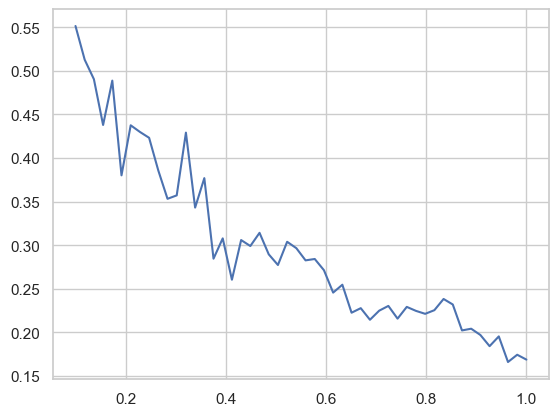

In [258]:
plt.plot(np.linspace(0.1, 1, 50), mcc_per_strategy)

In [259]:
sampling_strategy = 0.1
sm = RandomUnderSampler(random_state=42, sampling_strategy=sampling_strategy)
X_res, y_res = sm.fit_resample(X_train.drop(columns='Class'), X_train['Class'])
cat_features = [0, 30, 31]
model = CatBoostClassifier(iterations=100,
                        learning_rate=1,
                        depth=4, verbose=False)
model.fit(X_res, y_res, cat_features)

print('val kappa:', kappa_coef(X_val['Class'], model.predict(X_val.drop(columns='Class'))))
print('test kappa:', kappa_coef(X_test['Class'], model.predict(X_test.drop(columns='Class')))) 
print('val mcc:', mcc(X_val['Class'], model.predict(X_val.drop(columns='Class'))))
print('test mcc:', mcc(X_test['Class'], model.predict(X_test.drop(columns='Class'))))

val kappa: 0.5173097423279338
test kappa: 0.27259181448136666
val mcc: 0.5514837189843578
test mcc: 0.3490950818396591


Даже такой наивный подход может дать относительно неплохие результаты и улучшить наши метрики. Тем не менее, сейчас мы никак не используем информацию о распределении объектов в выборке. Оказывается, что даже относительно простые эвристические правила могут заметно поднять нам качество - например, мы можем при отбрасывании использовать близость отдельных объектов мажорного класса к минорному и отбрасывать самые близкие. Протестируйте алгоритм [Near-Miss](https://www.site.uottawa.ca/~nat/Workshop2003/jzhang.pdf) на наших данных и постройте графики, аналогичные предыдущему пункту (также добавьте график с зависимостью качества от числа соседей).

In [276]:
from imblearn.under_sampling import NearMiss

best_mcc = 0.0
best_strategy = None
mcc_per_strategy = []

for sampling_strategy in tqdm(np.linspace(0.1, 1, 50)):
    sm = NearMiss(sampling_strategy=sampling_strategy)
    X_res, y_res = sm.fit_resample(X_train.drop(columns='Class'), X_train['Class'])
    cat_features = [0, 30, 31]
    model = CatBoostClassifier(iterations=100,
                            learning_rate=1,
                            depth=4, verbose=False)
    model.fit(X_res, y_res, cat_features)
    preds_class = model.predict(X_val.drop(columns='Class'))
    new_mcc = mcc(X_val['Class'], preds_class)
    mcc_per_strategy.append(new_mcc)
    if best_mcc < new_mcc:
        best_mcc = new_mcc
        best_strategy = sampling_strategy

print('best strategy:', best_strategy)


  0%|          | 0/50 [00:00<?, ?it/s]

best strategy: 0.15510204081632656


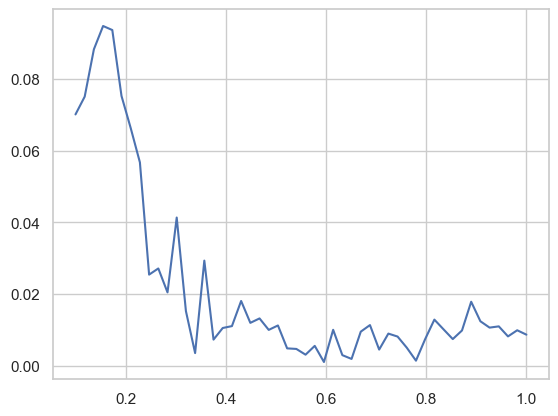

In [277]:
plt.plot(np.linspace(0.1, 1, 50), mcc_per_strategy)

In [265]:
sampling_strategy = 0.15510204081632656
sm = NearMiss(sampling_strategy=sampling_strategy)
X_res, y_res = sm.fit_resample(X_train.drop(columns='Class'), X_train['Class'])
cat_features = [0, 30, 31]
model = CatBoostClassifier(iterations=100,
                        learning_rate=1,
                        depth=4, verbose=False)
model.fit(X_res, y_res, cat_features)

print('val kappa:', kappa_coef(X_val['Class'], model.predict(X_val.drop(columns='Class'))))
print('test kappa:', kappa_coef(X_test['Class'], model.predict(X_test.drop(columns='Class')))) 
print('val mcc:', mcc(X_val['Class'], model.predict(X_val.drop(columns='Class'))))
print('test mcc:', mcc(X_test['Class'], model.predict(X_test.drop(columns='Class'))))

val kappa: 0.01906350655477878
test kappa: 0.00405425586083418
val mcc: 0.09479734832847117
test mcc: 0.04225343651945923


In [278]:
best_mcc = 0.0
best_n_neighbors = None
mcc_per_strategy = []

for n_neighbors in tqdm(np.arange(2, 30)):
    sm = NearMiss(sampling_strategy=0.15510204081632656, n_neighbors=n_neighbors)
    X_res, y_res = sm.fit_resample(X_train.drop(columns='Class'), X_train['Class'])
    cat_features = [0, 30, 31]
    model = CatBoostClassifier(iterations=100,
                            learning_rate=1,
                            depth=4, verbose=False)
    model.fit(X_res, y_res, cat_features)
    preds_class = model.predict(X_val.drop(columns='Class'))
    new_mcc = mcc(X_val['Class'], preds_class)
    mcc_per_strategy.append(new_mcc)
    if best_mcc < new_mcc:
        best_mcc = new_mcc
        best_n_neighbors = n_neighbors

print('best n_neighbors:', best_n_neighbors)


  0%|          | 0/28 [00:00<?, ?it/s]

best n_neighbors: 3


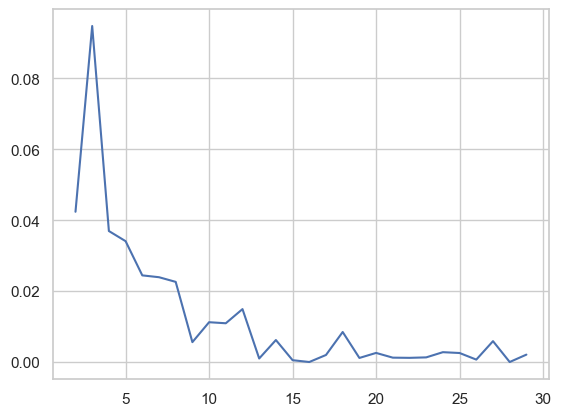

In [280]:
plt.plot(np.arange(2, 30), mcc_per_strategy)

In [281]:
sm = NearMiss(sampling_strategy=0.15510204081632656, n_neighbors=n_neighbors)
X_res, y_res = sm.fit_resample(X_train.drop(columns='Class'), X_train['Class'])
cat_features = [0, 30, 31]
model = CatBoostClassifier(iterations=100,
                        learning_rate=1,
                        depth=4, verbose=False)
model.fit(X_res, y_res, cat_features)

print('val kappa:', kappa_coef(X_val['Class'], model.predict(X_val.drop(columns='Class'))))
print('test kappa:', kappa_coef(X_test['Class'], model.predict(X_test.drop(columns='Class')))) 
print('val mcc:', mcc(X_val['Class'], model.predict(X_val.drop(columns='Class'))))
print('test mcc:', mcc(X_test['Class'], model.predict(X_test.drop(columns='Class'))))

val kappa: 8.6613285777801e-06
test kappa: 2.773484575814603e-06
val mcc: 0.0020810293231054064
test mcc: 0.0011776010406602006


че то все очень плохо

# Часть 2. Поиск аномалий. 

Как вы могли заметить, методы балансировки выборок очень часто могут привести к не самым лучшим результатам из-за того, что они по сути искажают информацию о реальном распределении данных - в реальности обычно требуется долгий подбор в принципе работоспособных для задачи методов и их аккуратная настройка. 

Теперь давайте попробуем слегка сменить постановку задачи и переключиться на задачу "одноклассовой" классификации, то есть - поиска *аномалий* в выборке. В общем-то, это вполне согласуется с нашей областью работы - мы действительно можем назвать мошеннические транзакции аномальньми (как интуитивно, так и на основании наблюдаемой балансировки данных). 

Стоит отметить, что методы обнаружения аномалий чаще всего относятся к классу методов обучения без учителя. Это дает некоторый положительный эффект - нам не обязательно нужно тратить время на разметку данных (тем не менее, для контроля качества какую-то часть разметить все-таки придется). Впрочем, чаще всего перфоманс таких методов оказывается заметно хуже, чем у честного обучения с учителем (если мы можем себе его позволить).



**Задание 4. (3 балла).** На занятиях вы разбирали схожий с Random Forest подход для детекции аномалий без известной разметки данных, называемый Isolation Forest. Напомним суть: на этапе обучения мы создаем ансамбль из решающих деревьев, в котором признак и порог на каждую вершину подбираются случайно. Затем мы считаем для объектов оценку аномальности через длину пути до соответствующего листа в каждом дереве.

В данном задании вам предлагается реализовать модификацию данного алгоритма, известную как Extended Isolation Forest. В ней мы на каждом шаге будем определять не порог для признака, а полноценную случайную гиперплоскость, разбивающую выборку на 2 части. С детальным описанием вы можете ознакомиться [здесь](https://arxiv.org/pdf/1811.02141.pdf).

Ниже приведен шаблон кода. Постарайтесь работать в его рамках (минорные изменения вполне допустимы, главное не переворачивайте всю структуру с ног на голову). 

**NB**: будем считать, что в нашем датасете нет категориальных признаков - можете не заморачиваться с их обработкой (но в общем случае, это будет важно).

**Советы**:
 - Численные признаки лучше предобработать надлежащим образом.
 - Возможно, вам поможет выбрасывание некоторых признаков.
 - Внимательно следите за знаками.
 - Не игнорируйте документирующие строки.
 - Вероятнее всего, вы не сможете приблизиться по качеству к supervised-решениям. Если у вас не получается это сделать (но вы уверены в своей правоте), не стоит тратить слишком много времени на поиск ошибок.



**Бонусы (каждый по 0.5)**:
- Сделайте ваш EIF параллельным (`multiprocessing`, `joblib`).
- Добавьте возможность откатиться к дефолтному варианту Isolation Forest. (порассуждайте, как можно реализовать это в данной модели?):


In [21]:
import numpy as np
from tqdm.notebook import tqdm

In [9]:
class Node(object):
    """
    A single node object for each tree. Contains information on height, current data,
    splitting hyperplane and children nodes.
    
    Attributes:
        X: np.array - data available to current node
        size: int - length of available data
        
        depth: int - depth of node

        left: Node - left child
        right: Node - right child

        kind: str - either "internal" or "external", indicates the type of current node

        w: np.array - normal vector for the splitting hyperplane
        b: float - intercept term for the splitting hyperplane
    """
    def __init__(self, X, depth, left, right, kind, w, b):
        """
        Node(h, left, right, kind, w, b)
        Represents the node object.
        
        Params:
            X: np.array - data available to current node
            depth: int - depth of node
            
            left: Node - left child
            right: Node - right child
            
            kind: str - either "internal" or "external", indicates the type of current node
            
            w: np.array - normal vector for the splitting hyperplane
            b: float - intercept term for the splitting hyperplane
            
        """
        self.size = len(X)
        
        self.depth = depth
        
        self.left = left
        self.right = right
        
        self.kind = kind
    
        self.w = w
        self.b = b
    
    def __repr__(self):
        """
        For convenience only.
        """
        return f"Node(size={self.size}, depth={self.depth}, kind={self.kind})"
    

def H(n):
    return np.log(n) + 0.5772156649

def c_factor(n):
    """
    Computes average path length for an unsuccessful search in a binary search tree.
    Params:
        n: int - number of data points for BST
    """
    if n == 0:
        return 0
    if n == 1:
        return 1
    return 2 * H(n - 1) - 2 * (n - 1) / n

def calc_height(X, depth, node : Node):
    """
    Calculates anomaly scores for sample in a recursive manner.
    Params:
        X: np.array - current sample, available to node
        
        depth: int - path length up to current node
        
        node: Node - current tree node
        
    Returns:
        scores: int, float or np.array - anomaly scores for sample
    """
    heights = np.zeros(X.shape[0])

    if node.kind == 'external':
        heights += node.depth + c_factor(node.size)
        return heights

    vals = X @ node.w + node.b
    left_idx = vals < 0
    right_idx = vals >= 0

    # print(sum(left_idx), sum(right_idx))

    left_heights = calc_height(X[left_idx], depth + 1, node.left)
    right_heights = calc_height(X[right_idx], depth + 1, node.right)

    heights[left_idx] = left_heights
    heights[right_idx] = right_heights

    return heights


class RandomizedTree(object):
    """
    Single randomized tree object. Stores root and its depth (tree is built recursively).
    Attributes:
        depth: int - current tree depth
        
        max_depth: int - maximum tree depth
        
        root: Node - root node 

        internal_count: int - number of internal nodes

        external_count: int - number of external nodes
        
    """
    def __init__(self, X, max_depth):
        """
        Single randomized tree object. Stores root and its depth (tree is built recursively).
        Params:
            X: np.array - train sample
            max_depth: int - maximum tree depth

        """
        self.depth = 0
        self.max_depth = max_depth
        
        self.internal_count = 0
        self.external_count = 0

        self.root = self.grow(X, 0)
        
    def __repr__(self):
        """
        For convenience only.
        """
        
        return f"RandomizedTree(depth={self.depth}, max_depth={self.max_depth}, n_internal={self.internal_count}, n_external={self.external_count})"

        
    def grow(self, X, depth):
        """
        Grow tree in a recursive manner.
        Params:
            X: np.array - available train sample
            
            depth: int - current tree depth
            
        Returns:
            node: Node - a trained node with separating hyperplane data.
                         Node provides access to children if necessary (these are built recursively)
        """
        
        if depth == self.max_depth or X.shape[0] <= 1:
            self.depth = max(depth, self.depth)
            self.external_count += 1
            return Node(X, depth, None, None, 'external', None, None)
        
        w = np.random.randn(X.shape[1])
        b = np.random.normal()

        vals = X @ w + b

        #print(vals.mean(), vals.std())
        # print(vals)

        left_idx = vals < 0
        right_idx = vals >= 0

        # print(sum(left_idx), sum(right_idx))
        
        left = self.grow(X[left_idx], depth + 1)
        right = self.grow(X[right_idx], depth + 1)
        
        self.internal_count += 1
        return Node(X, depth, left, right, 'internal', w, b)

    def score_samples(self, X):
        """
        Calculate anomaly scores for given data. You may utilize outer function `calc_height`.
        Params:
            X: np.array - data to be evaluated
            
        Returns:
            scores: np.array - estimated anomaly scores
        """
        scores = calc_height(X, 0, self.root)
        return scores
        
    
class ExtendedIsolationForest(object):
    """
    Extended Isolation Forest object. Stores training data and trained randomized trees.
    Attributes:
        n_trees: int - number of Randomized Trees
        
        max_depth: int - maximum depth of each tree
        
        subsample_rate: float - draw `subsample_rate * X.shape[0]` samples for each tree
        
        trees: list - container for trained trees 
        
        contamination: float - estimated fraction of anomaly samples in data. Used for thresholding
        
    """
    
    def __init__(self, n_trees, subsample_rate, max_depth=None, contamination=0.01):
        """
        Extended Isolation Forest object. Stores training data and trained randomized trees.
        Params:
            n_trees: int - number of Randomized Trees

            subsample_rate: float - draw `subsample_rate * X.shape[0]` samples for each tree

            max_depth: int or None - maximum depth of each tree. Defaults to ceil(log_2(subsample_size)) if not provided

            contamination: float - estimated fraction of anomaly samples in data. Used for thresholding

        """
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.subsample_rate = subsample_rate
        self.trees = []
        self.contamination = contamination
        self.is_fit = False
        self.data_points_q = None
        
    def __repr__(self):
        """For convenience only."""
        
        return f"ExtendedIsolationForest(n_trees={self.n_trees}, max_depth={self.max_depth}, subsample_rate={self.subsample_rate}, contamination={self.contamination}, is_fit={self.is_fit})"
        
    def fit(self, X):
        """
        Fit EIF to new data.
        Params:
            X: np.array - 2d array of samples
        """
        self.data_points_q = np.int32(self.subsample_rate * X.shape[0])
        if self.max_depth is None:
            self.max_depth = np.ceil(np.log2(self.data_points_q))
        self.is_fit = True
        np.random.seed(42)
        idx = np.random.choice(np.arange(X.shape[0]), size=self.data_points_q, replace=False)

        print(f'taking {self.data_points_q} samples out of {X.shape[0]}')
        
        for i in tqdm(range(self.n_trees)):
            self.trees.append(RandomizedTree(X[idx], self.max_depth))
        return self
    
    def score_samples(self, X):
        """
        Estimate (normalized) anomaly score for each given sample
        Params:
            X: np.array - new samples

        Returns:
            scores: np.array - anomaly scores (larger value means higher probability of a sample being an outlier)
        """
        print(X.shape[0])
        mean = np.zeros(X.shape[0])
        for tree in tqdm(self.trees):
            mean += tree.score_samples(X)

        mean /= self.n_trees
        scores = 2 ** (-mean / c_factor(self.data_points_q))

        return scores

    
    def predict(self, X):
        """
        Predict if given samples are outliers.
        Params:
            X: np.array - new samples

        Returns:
            labels: np.array - anomaly labels (1 for outliers, 0 for inliers)
        """
        scores = self.score_samples(X)
        labels = (scores >= np.quantile(scores, 1 - self.contamination))
        # labels = (scores >= scores.mean())
        return labels, scores


**Задание 5. (1 балл).** Протестируйте вашу реализацию EIF и подберите оптимальные гиперпараметры (наш метод не использует разметку, поэтому можете попробовать делать это на обучающей выборке). Сравните ее с обычным IF из `sklearn` (желательно делать это на одних и тех же параметрах). Удалось ли сделать лучше?

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.drop(columns='Class'))
X_test_scaled = scaler.transform(X_test.drop(columns='Class'))
X_val_scaled = scaler.transform(X_val.drop(columns='Class'))

In [11]:
from sklearn.metrics import precision_recall_curve, auc

def auc_pr(y_true, y_pred):
    prec, rec, _ = precision_recall_curve(y_true, y_pred)
    return auc(rec, prec)

Перебрал разные гиперпараметры, эти дают самый высокий mcc/kappa и неплохой auc-pr 

In [12]:
model = ExtendedIsolationForest(100, 1, 8, 0.01)
model.fit(X_train_scaled)

taking 227846 samples out of 227846


  0%|          | 0/100 [00:00<?, ?it/s]

ExtendedIsolationForest(n_trees=100, max_depth=8, subsample_rate=1, contamination=0.01, is_fit=True)

In [16]:
test_pred, test_scores = model.predict(X_test_scaled)

print('EIF kappa:', kappa_coef(X_test['Class'], test_pred))
print('EIF mcc:', mcc(X_test['Class'], test_pred))
print('EIF auc-pr:', auc_pr(X_test['Class'], test_pred))

28481


  0%|          | 0/100 [00:00<?, ?it/s]

EIF kappa: 0.09642397825618679
EIF mcc: 0.18766704520088212
EIF auc-pr: 0.36734776932628127


Возможно, ваш алгоритм выдал большие оценки объектам с негативной разметкой. Постарайтесь выбрать несколько таких объектов и доступно объяснить (= с кодом и графиками), почему так вышло:

In [122]:
sort_idx = np.argsort(test_scores[X_test['Class'] == 0])

Возьмем 20 негативных объектов с самой большой разметкой

In [123]:
neg_obj_with_big_scores = X_test[X_test['Class'] == 0].iloc[sort_idx[-20:]]

In [124]:
neg_obj_with_big_scores

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Hour,Day
267217,-1.272113,0.068039,0.582609,4.097004,-3.310319,5.179480,5.400805,-1.175404,-1.894854,1.482092,0.229732,-0.856864,1.258788,-0.884529,1.005968,1.038460,-1.274790,1.376447,1.639514,-0.066322,-0.268708,0.720659,-0.235109,-0.241588,0.323601,0.516139,0.113391,-0.922299,1133.88,0,21,1
271810,-15.622687,-13.011941,-8.330979,8.860364,-8.640796,4.839857,6.164138,-0.595616,-1.179146,0.472436,-0.059583,0.440708,1.480926,1.706326,1.945092,3.434636,0.014204,1.268959,0.979564,-2.366295,-0.208414,-1.125043,-8.102468,1.138071,-1.738299,0.326575,3.276514,-3.250235,1875.48,0,21,1
265283,-4.276866,-2.351261,0.779925,5.683857,1.163263,0.193968,-2.090351,-3.126043,-1.112571,1.638437,-1.012344,-0.687348,-0.388245,0.424637,1.819049,0.886377,0.054206,0.270834,0.890418,-1.840792,-1.846139,0.776956,-3.868809,0.365492,-1.406257,0.475776,1.689813,-0.445367,758.58,0,20,1
262178,-6.193345,3.743459,-2.755558,-2.138186,-3.521355,0.329836,-4.331610,-3.682092,1.668506,-1.368702,-2.006453,1.827548,0.053146,1.874911,0.704863,0.095265,1.498139,0.762450,0.757832,-2.254836,6.820133,-0.994141,0.746331,-0.115762,-0.060923,-0.083951,-1.518275,-0.101944,36.00,0,20,1
271962,-2.056673,2.204844,-1.979134,0.149720,3.428212,1.015140,-6.803024,-10.062100,-1.283291,-3.229818,1.730693,1.973798,-0.306504,-0.577694,0.916689,0.693109,2.866188,0.528501,-1.791011,2.338888,-4.832522,1.693413,-3.893988,-1.667340,-0.021368,0.049621,0.240402,0.506780,1.00,0,21,1
271853,-18.479164,-15.726967,-9.410119,9.739257,-7.635013,3.553671,4.550106,0.008685,-0.946745,0.655153,-0.167960,0.900855,1.746797,2.175219,2.137045,3.668589,0.245755,1.259988,0.808516,-1.733186,-0.037107,-1.706726,-10.117548,1.250139,-2.141659,0.173716,2.670597,-3.095313,1350.90,0,21,1
271773,-12.445555,-9.899507,-6.622124,7.777677,-8.651513,5.582699,7.198959,-0.718150,-1.557141,0.255170,-0.078356,-0.103489,1.140236,1.219640,1.584698,2.983646,-0.209193,1.496537,1.240575,-2.190840,-0.118345,-0.127672,-2.565750,0.782798,-0.526436,0.524346,3.180379,-3.260522,1783.26,0,21,1
271772,-5.153221,0.539706,-0.689382,1.320317,-0.864433,2.240697,-2.936963,-8.012247,-0.441292,-0.631442,0.623720,1.550537,0.142896,1.101551,0.472399,0.944118,-0.098894,1.075245,0.307622,-0.899446,0.322245,0.838864,0.606083,0.740160,0.024977,-0.365926,0.904607,-0.121755,192.60,0,21,1
261843,-26.389030,-17.755687,-10.278766,10.413010,-9.446086,6.220135,7.705953,-2.311311,5.501918,7.223713,0.727981,0.246398,1.819804,-3.104880,2.065221,3.801851,-0.865402,-0.524366,3.189471,-14.141898,-5.979891,-0.215655,-9.002474,1.126551,0.396670,0.220177,-6.592504,15.373170,1441.06,0,20,1
275590,-2.074173,2.542825,-0.408849,0.964889,-2.080833,2.519724,-4.746074,-11.505696,0.658514,-0.546830,-1.210236,0.749030,-0.906732,1.135704,1.681184,-0.421953,1.246773,0.762016,1.975519,0.041627,3.719067,-0.548923,0.809661,-0.168330,0.345735,0.671787,0.532920,0.356190,99.95,0,22,1


Во первых сразу видим, что они идут практически подряд по времени (в среднем в 20-22 часа) и именно в 1 день, что странно потому что в это время больше всего транзакций, но мошеннических мало (знаем из графиков в начале ноутбука). 

In [131]:
trees_external = []
trees_internal = []

for tree in model.trees:
    trees_external.append(tree.external_count)
    trees_internal.append(tree.internal_count)
    print(tree.external_count, tree.internal_count)

256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255
255 254
256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255
255 254
256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255
256 255


In [130]:
print('external', np.mean(trees_external), np.std(trees_external))
print('internal', np.mean(trees_internal), np.std(trees_internal))

external 255.98 0.13999999999999999
internal 254.98 0.13999999999999999


Видим, что с небольшим отклонением все деревья имеют различающееся на 1 количество внутренних и внешних нод, то есть получаются полные двоичные деревья, так что с высокой вероятностью в этих нодах примерно одинаковое число вершин, из-за этого классификация происходит не очень качественно и даже такие вершины могут иметь высокий скор 

**Задание 6. (1 балл).** `sklearn` также предлагает нам и другие методы для поиска аномалий. В этом задании мы предлагаем вам сделать следующее:

Для начала попробуйте использовать методы Local Outlier Factor и One-Class SVM. Сравните результаты с IF и EIF.  

In [19]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest

In [132]:
clf = IsolationForest(random_state=42, max_features=30).fit(X_train_scaled)
test_pred = (clf.predict(X_test_scaled) == -1)

print('IF kappa:', kappa_coef(X_test['Class'], test_pred))
print('IF mcc:', mcc(X_test['Class'], test_pred))
print('IF auc-pr:', auc_pr(X_test['Class'], test_pred))

IF kappa: 0.02791295847695465
IF mcc: 0.10726241580300723
IF auc-pr: 0.41664242810244595


In [133]:
test_pred = LocalOutlierFactor(p=2, contamination=0.01).fit_predict(X_test_scaled)

print('LOF kappa:', kappa_coef(X_test['Class'], test_pred))
print('LOF mcc:', mcc(X_test['Class'], test_pred))
print('LOF auc-pr:', auc_pr(X_test['Class'], test_pred))

LOF kappa: -0.00013281647269312304
LOF mcc: 0.0
LOF auc-pr: 0.40948032555628616


In [134]:
test_pred = LocalOutlierFactor(p=3, contamination=0.01).fit_predict(X_test_scaled)

print('LOF kappa:', kappa_coef(X_test['Class'], test_pred))
print('LOF mcc:', mcc(X_test['Class'], test_pred))
print('LOF auc-pr:', auc_pr(X_test['Class'], test_pred))

LOF kappa: -0.00013281647269312304
LOF mcc: 0.0
LOF auc-pr: 0.40948032555628616


In [135]:
test_pred = OneClassSVM(nu=0.5).fit_predict(X_test_scaled)

print('OneClassSVM kappa:', kappa_coef(X_test['Class'], test_pred))
print('OneClassSVM mcc:', mcc(X_test['Class'], test_pred))
print('IOneClassSVMF auc-pr:', auc_pr(X_test['Class'], test_pred))

OneClassSVM kappa: -0.00035128763871468524
OneClassSVM mcc: 0.0
IOneClassSVMF auc-pr: 0.02313104698652324


In [136]:
test_pred = OneClassSVM(nu=0.7).fit_predict(X_test_scaled)

print('OneClassSVM kappa:', kappa_coef(X_test['Class'], test_pred))
print('OneClassSVM mcc:', mcc(X_test['Class'], test_pred))
print('OneClassSVMF auc-pr:', auc_pr(X_test['Class'], test_pred))

OneClassSVM kappa: -0.00023180614294565085
OneClassSVM mcc: 0.0
OneClassSVMF auc-pr: 0.0003862223938766195


In [137]:
test_pred = OneClassSVM(nu=0.2).fit_predict(X_test_scaled)

print('OneClassSVM kappa:', kappa_coef(X_test['Class'], test_pred))
print('OneClassSVM mcc:', mcc(X_test['Class'], test_pred))
print('OneClassSVMF auc-pr:', auc_pr(X_test['Class'], test_pred))

OneClassSVM kappa: -0.0005130263106807764
OneClassSVM mcc: 0.0
OneClassSVMF auc-pr: 0.06858119800357754


Метрики снова получились не лучше чем у самых первых попыток в начале ноутбука. По метрикам kappa и mcc EIF дает наилучшие показатели, но auc-pr выше у реализации IF из sklearn. LocalOutlierFactor показал нулевые kappa и mcc, но auc-pr примерно как у IF. OneClassSVM показал наихудшие резы, все три метрики очень низкие

У вас началась депрессия из-за плохих метрик? Не беда! Сейчас давайте сделаем так: все методы, опробованные в этой части, попробуем задействовать для создания дополнительных признаков в данных. Проделайте это (не забудьте, что обучаться здесь нужно на трейне). Теперь возьмите лучшую модель из предыдущей части и обучите на новых данных. Смогли ли unsupervised-методы повысить вам качество?

In [20]:
X_train['oneSVM'] = OneClassSVM(nu=0.01).fit_predict(X_train_scaled)

/var/folders/zx/wrwkdswj43x8h8lg01g13ry00000gq/T/ipykernel_38647/2410729722.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['oneSVM'] = OneClassSVM(nu=0.01).fit_predict(X_train_scaled)


In [22]:
X_train['LOF'] = LocalOutlierFactor(p=2, contamination=0.01).fit_predict(X_train_scaled)

/var/folders/zx/wrwkdswj43x8h8lg01g13ry00000gq/T/ipykernel_38647/388080286.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['LOF'] = LocalOutlierFactor(p=2, contamination=0.01).fit_predict(X_train_scaled)


In [29]:
clf = IsolationForest(random_state=42, max_features=30).fit(X_train_scaled)
X_train['IF'] = np.int32(clf.predict(X_train_scaled) == -1)

/var/folders/zx/wrwkdswj43x8h8lg01g13ry00000gq/T/ipykernel_38647/2246092426.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['IF'] = np.int32(clf.predict(X_train_scaled) == -1)


In [30]:
X_train

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Hour,Day,oneSVM,LOF,IF
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0.0,0.0,1,1,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0.0,0.0,1,1,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,0.0,0.0,1,1,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0.0,0.0,1,1,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0.0,0.0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227841,0.306600,1.116021,-0.047348,3.593785,2.079047,5.748707,-2.059246,-1.352120,-1.849240,1.000154,-0.330464,-0.202383,-0.129313,0.713813,1.309414,0.399616,0.038217,-0.097967,0.632624,0.865457,-1.458527,-0.234478,0.258831,0.639005,-0.048250,0.144586,0.216385,0.304545,0.76,0,16.0,1.0,1,1,0
227842,-1.781954,2.062680,-3.758871,-1.801001,-0.084365,1.919610,-1.454364,-9.825473,-2.073119,-0.005816,-0.644403,0.982035,0.243801,1.541216,-1.949005,-1.278610,-0.179722,1.616439,-0.740407,-0.690810,1.234747,0.376804,-0.339706,-0.216688,-1.555393,0.655873,0.777662,0.272753,359.28,0,16.0,1.0,-1,1,1
227843,-0.061507,1.024900,-0.170060,-0.263220,0.982164,-1.162749,1.468942,-0.648407,-0.157586,-0.764370,-0.442168,0.024224,0.865039,-1.203879,0.627917,-0.103494,0.238910,0.634188,-0.030689,0.035225,0.299618,1.177722,-0.296209,-0.140335,-0.465171,-0.197933,-0.048916,0.023871,39.40,0,16.0,1.0,1,1,0
227844,2.050034,-0.103557,-1.204713,0.207198,0.108850,-0.665621,0.073598,-0.164464,0.303531,0.242471,0.614559,1.016880,0.081998,0.441357,-0.635926,0.203137,-0.682642,-0.251580,0.582943,-0.201782,-0.263799,-0.654763,0.280573,-0.405691,-0.274672,0.202719,-0.074529,-0.074279,0.17,0,16.0,1.0,1,1,0


In [31]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[:int(0.8 * X_train.shape[0])].drop(columns='Class'))
X_test_scaled = scaler.transform(X_train[int(0.8 * X_train.shape[0]):].drop(columns='Class'))

In [32]:
model = ExtendedIsolationForest(100, 1, 8, 0.01)
model.fit(X_train_scaled)

taking 182276 samples out of 182276


  0%|          | 0/100 [00:00<?, ?it/s]

ExtendedIsolationForest(n_trees=100, max_depth=8, subsample_rate=1, contamination=0.01, is_fit=True)

In [35]:
test_pred, test_scores = model.predict(X_test_scaled)

print('EIF kappa:', kappa_coef(X_train[int(0.8 * X_train.shape[0]):]['Class'], test_pred))
print('EIF mcc:', mcc(X_train[int(0.8 * X_train.shape[0]):]['Class'], test_pred))
print('EIF auc-pr:', auc_pr(X_train[int(0.8 * X_train.shape[0]):]['Class'], test_pred))

45570


  0%|          | 0/100 [00:00<?, ?it/s]

EIF kappa: 0.11235480563356069
EIF mcc: 0.1859869389926124
EIF auc-pr: 0.31089675846830833


Ну стало немного поувереннее, но auc-pr просел маленько

**Бонус. (0.1 балла).**

При сдаче проверяющий запустит следующую клетку один раз. Если она даст положительный результат, вы получите 0.1 бонусных балла. Если она даст отрицательный результат, вы получите -0.1 бонусных балла. 

Если вы хотите отказаться от сдачи данного задания, допишите "хочу" после двоеточия: `your text here`

Ниже вы можете попрактиковаться и оценить ваши силы (изменять код ячейки запрещается!)

In [63]:
import random

rng = random.SystemRandom(0)
rng.uniform(-1.0, 1.0)

0.36980588775220746

In [62]:
ans = 0

for i in range(1000):
    rng = random.SystemRandom(0)
    ans += rng.uniform(-1.0, 1.0)

ans / 1000

0.021612528210580483

я считаю это успех